# Multi-Label Classification: Google Quest Challenge

## IST664 Natural Language Processing: Group 4: Project



**Sharvil Arjunwadkar<br>
Aadil Zikre<br>
Vipul Sarode<br>
Gowtham Behara<br>
Sai Naga Venkata Lakshmi Kalyan Medavarapu**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Install the required package
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### IMPORT REQUIRED PACKAGES

In [ ]:
#Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from imblearn.over_sampling import RandomOverSampler
import torch
import torch.nn
import re
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader

from nltk import WordNetLemmatizer
# import emoji

# Utility functions from TF
import keras
import tensorflow as tf 
from keras import layers
from keras import losses
from keras import utils
#from tensorflow.keras import preprocessing
from keras.utils import pad_sequences

from tqdm.notebook import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout

from collections import defaultdict

print("Success")

Success


### DATA LOAD & PREPROCESSING

In [ ]:
#import the dataset
df_train = pd.read_csv("/content/drive/MyDrive/NLP_Project/train.csv")

In [ ]:
#View first 6 lines
df_train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [ ]:
#View the structure
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   qa_id                                  6079 non-null   int64  
 1   question_title                         6079 non-null   object 
 2   question_body                          6079 non-null   object 
 3   question_user_name                     6079 non-null   object 
 4   question_user_page                     6079 non-null   object 
 5   answer                                 6079 non-null   object 
 6   answer_user_name                       6079 non-null   object 
 7   answer_user_page                       6079 non-null   object 
 8   url                                    6079 non-null   object 
 9   category                               6079 non-null   object 
 10  host                                   6079 non-null   object 
 11  ques

In [ ]:
#Make a copy of the original training df
df_train_1 = df_train.copy()

In [ ]:
#A list of all the labels available for questions
question_labels = [i for i in df_train.columns if i.startswith("question_")]
#There are 21 Labels and 4 Question related info like title, body and user info

#A list of all the labels available for answers
answer_labels = [i for i in df_train.columns if i.startswith("answer_")]
#There are 9 Labels and 2 Answer related info like user info  

In [ ]:
#Question Labels are values that have a value between 0 to 1(Basically Probability).
#Here we are trying to see what are the values for these labels at following 5 quantiles:
#0%, 25%, 50%, 75% and 100%
#We are taking question_labels from 4 as first 4 are not labels, they are the title, body and 
#user info related to question
for i in question_labels[4:]:
    #Print the label name
    print(i)
    #Print the quantile values
    print(df_train[i].quantile([0,0.25,0.5,0.75,1]))
#     df_train[i].hist()
#     plt.show()

question_asker_intent_understanding
0.00    0.333333
0.25    0.777778
0.50    0.888889
0.75    1.000000
1.00    1.000000
Name: question_asker_intent_understanding, dtype: float64
question_body_critical
0.00    0.333333
0.25    0.444444
0.50    0.555556
0.75    0.777778
1.00    1.000000
Name: question_body_critical, dtype: float64
question_conversational
0.00    0.0
0.25    0.0
0.50    0.0
0.75    0.0
1.00    1.0
Name: question_conversational, dtype: float64
question_expect_short_answer
0.00    0.000000
0.25    0.500000
0.50    0.666667
0.75    1.000000
1.00    1.000000
Name: question_expect_short_answer, dtype: float64
question_fact_seeking
0.00    0.000000
0.25    0.666667
0.50    1.000000
0.75    1.000000
1.00    1.000000
Name: question_fact_seeking, dtype: float64
question_has_commonly_accepted_answer
0.00    0.000000
0.25    0.666667
0.50    1.000000
0.75    1.000000
1.00    1.000000
Name: question_has_commonly_accepted_answer, dtype: float64
question_interestingness_others
0.00   

In [ ]:
#Answer Labels are values that have a value between 0 to 1(Basically Probability).
#Here we are trying to see what are the values for these labels at following 5 quantiles:
#0%, 25%, 50%, 75% and 100%
#We are taking answer_labels from 2 as first 2 are not labels, they are the answer and 
#user info related to answer
for i in answer_labels[2:]:
    #Print the answer label
    print(i)
    #print the quantile values
    print(df_train[i].quantile([0,0.25,0.5,0.75,1]))

answer_helpful
0.00    0.333333
0.25    0.888889
0.50    1.000000
0.75    1.000000
1.00    1.000000
Name: answer_helpful, dtype: float64
answer_level_of_information
0.00    0.333333
0.25    0.666667
0.50    0.666667
0.75    0.666667
1.00    1.000000
Name: answer_level_of_information, dtype: float64
answer_plausible
0.00    0.333333
0.25    1.000000
0.50    1.000000
0.75    1.000000
1.00    1.000000
Name: answer_plausible, dtype: float64
answer_relevance
0.00    0.333333
0.25    1.000000
0.50    1.000000
0.75    1.000000
1.00    1.000000
Name: answer_relevance, dtype: float64
answer_satisfaction
0.00    0.200000
0.25    0.800000
0.50    0.866667
0.75    0.933333
1.00    1.000000
Name: answer_satisfaction, dtype: float64
answer_type_instructions
0.00    0.0
0.25    0.0
0.50    0.5
0.75    1.0
1.00    1.0
Name: answer_type_instructions, dtype: float64
answer_type_procedure
0.00    0.000000
0.25    0.000000
0.50    0.000000
0.75    0.333333
1.00    1.000000
Name: answer_type_procedure, dty

In [ ]:
#Getting the Value Count for the Label to check if the labels are balanced
df_train.question_not_really_a_question.value_counts()

0.000000    6013
0.333333      48
0.500000      11
0.666667       4
1.000000       3
Name: question_not_really_a_question, dtype: int64

In [ ]:
#Getting the Value Count for the question_label to check if the labels are balanced
#before modifications
for i in question_labels[4:]:
    #Print the label name
    print(i)
    #Print the value counts
    print(df_train[i].value_counts())

question_asker_intent_understanding
1.000000    2833
0.888889    1579
0.777778     883
0.666667     503
0.833333     108
0.333333      68
0.555556      60
0.500000      33
0.444444      12
Name: question_asker_intent_understanding, dtype: int64
question_body_critical
0.333333    1506
0.555556     932
0.444444     893
0.666667     845
0.777778     701
1.000000     583
0.888889     470
0.500000      94
0.833333      55
Name: question_body_critical, dtype: int64
question_conversational
0.000000    5409
0.333333     384
0.666667     152
1.000000     104
0.500000      30
Name: question_conversational, dtype: int64
question_expect_short_answer
1.000000    2936
0.666667    1373
0.000000     806
0.333333     522
0.500000     442
Name: question_expect_short_answer, dtype: int64
question_fact_seeking
1.000000    3480
0.666667    1326
0.333333     877
0.000000     315
0.500000      81
Name: question_fact_seeking, dtype: int64
question_has_commonly_accepted_answer
1.000000    4071
0.666667     794

**Initially we are trying to set a threshold of 0.5 and label the questions based on the major label values that we find in the question_labels. To do this we need to have 0 or 1 label values instead of values between 0 to 1.**

In [ ]:
#Get the labels with either 0 or 1 values instead of a value in the range 0-1
df_train.iloc[:, 11:] = df_train.iloc[:, 11:].apply(lambda x: pd.Series([1 if val >= 0.5 else 0 for val in x]))

<ipython-input-100-82983c7102ba>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:, 11:] = df_train.iloc[:, 11:].apply(lambda x: pd.Series([1 if val >= 0.5 else 0 for val in x]))


In [ ]:
#Check the first 6 records
df_train.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1,1,1,1,1,1,1,0,0,1
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,1,1,1,1,1,1,0,0,1,1
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,1,1,1,1,1,1,0,0,1,1
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,1,1,0,1,1,1,0,0,1,1
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1,1,1,1,1,1,1,0,1,1


In [ ]:
#Getting the Value Count in absolute and percentage for the question_label to
#check if the labels are balanced after modifications
for i in question_labels[4:]:
    #Print the label name
    print(i)
    #Print the value counts in percentage
    print(df_train[i].value_counts(normalize=True))
    print(df_train[i].value_counts())

question_asker_intent_understanding
1    0.98684
0    0.01316
Name: question_asker_intent_understanding, dtype: float64
1    5999
0      80
Name: question_asker_intent_understanding, dtype: int64
question_body_critical
1    0.605363
0    0.394637
Name: question_body_critical, dtype: float64
1    3680
0    2399
Name: question_body_critical, dtype: int64
question_conversational
0    0.952953
1    0.047047
Name: question_conversational, dtype: float64
0    5793
1     286
Name: question_conversational, dtype: int64
question_expect_short_answer
1    0.781543
0    0.218457
Name: question_expect_short_answer, dtype: float64
1    4751
0    1328
Name: question_expect_short_answer, dtype: int64
question_fact_seeking
1    0.803915
0    0.196085
Name: question_fact_seeking, dtype: float64
1    4887
0    1192
Name: question_fact_seeking, dtype: int64
question_has_commonly_accepted_answer
1    0.838625
0    0.161375
Name: question_has_commonly_accepted_answer, dtype: float64
1    5098
0     981
Name

**The Labels are imbalanced based on the analysis of the data that we conducted. Therefore, we need a way to balance the labels so that the model does not become bias on the majority class. Based on the analysis and taking 85% for majority class and 15% for minority class as the distribution, we need to perform oversampling on the labels where the imbalance crosses this threshold.**

### OVERSAMPLER & FUNCTIONS

In [ ]:
### This is something we tried to see how the Oversampling works on one of the labels

# # define the oversampling ratio
# oversample_ratio = 0.05/0.95  # desired ratio of majority class to minority class

# # create the oversampler object
# oversampler = RandomOverSampler(sampling_strategy=oversample_ratio, random_state=0)

# # fit and apply the oversampler to the data
# X_resampled, y_resampled = oversampler.fit_resample(df_train.drop("question_asker_intent_understanding", axis=1), df_train['question_asker_intent_understanding'])

In [ ]:
#Create a function to perform Random Oversampling
#It take 3 inputs: dataframe, column on which to run and a oversample ratio
#Taking Oversampling ratio of 15% isto 85% i.e., 
#minority class: 15% and majority class: 85%
def df_oversampler(df, col, oversample_ratio = 0.15/0.85):
  #Initialize an instance of Random Smapler
  oversampler = RandomOverSampler(sampling_strategy=oversample_ratio, random_state=0)
  #Fit the data to the Random Sampler
  X_resampled, y_resampled = oversampler.fit_resample(df_train.drop(col, axis=1), df_train[col])
  #Return the processed data
  return X_resampled, y_resampled

In [ ]:
#Create a function to perform Random Oversampling
#It take 3 inputs: dataframe, column on which to run and a oversample ratio
#Taking Oversampling ratio of 15% isto 85% i.e., 
#minority class: 15% and majority class: 85%
def array_oversampler(array_x, array_y, oversample_ratio = 0.15/0.85):
  #Initialize an instance of Random Smapler
  oversampler = RandomOverSampler(sampling_strategy=oversample_ratio, random_state=0)
  #Fit the data to the Random Sampler
  X_resampled, y_resampled = oversampler.fit_resample(array_x, array_y)
  #Return the processed data
  return X_resampled, y_resampled

In [ ]:
#Testing the function
X_resampled, y_resampled = df_oversampler(df_train, "question_asker_intent_understanding")

### MODEL MAX SENTENCE LENGTH EDA

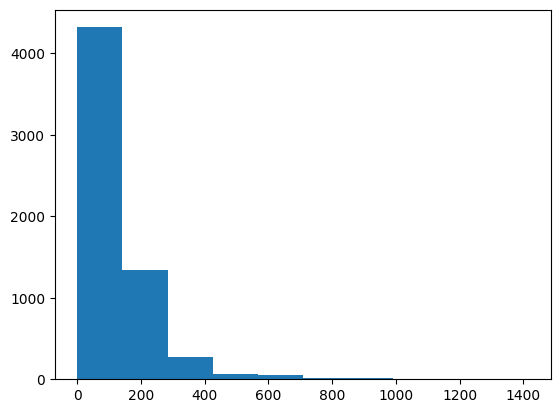

MAX: 1416 
MEDIAN: 92
MEAN: 125.2636946866261
75th Percentile: 154.0
These are the results before any data-preprocessing on the question_body


In [ ]:
#We are trying to determine what should be the allowed maximum length of a sentence

#Create a empty list
length_question_body = []

#Iterate the reviewText and make a list of sentences
for sen in df_train["question_body"]:
  length = len(sen.split())
  length_question_body.append(length)

#Plot a histogram to show the length of each sentence
plt.hist(length_question_body)
plt.show()

#Print the descriptive statistics
print("MAX: {} ".format(max(length_question_body)))
print("MEDIAN: {}".format(statistics.median(length_question_body)))
print("MEAN: {}".format(statistics.mean(length_question_body)))
print("75th Percentile: {}".format(np.percentile(length_question_body, 75)))
print("These are the results before any data-preprocessing on the question_body")

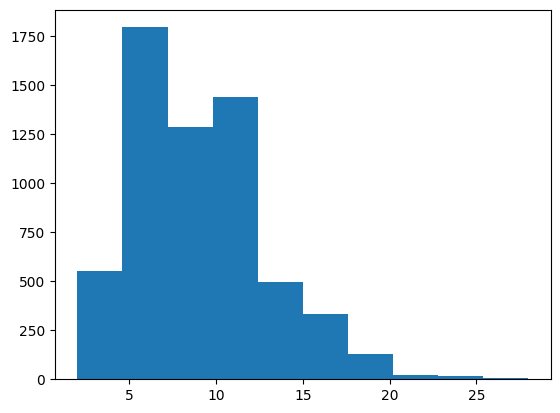

MAX: 28 
MEDIAN: 9
MEAN: 9.034874156933705
75th Percentile: 11.0
These are the results before any data-preprocessing on the question_title


In [ ]:
#We are trying to determine what should be the allowed maximum length of title

#Create a empty list
length_question_title = []

#Iterate the reviewText and make a list of sentences
for sen in df_train["question_title"]:
  length = len(sen.split())
  length_question_title.append(length)

#Plot a histogram to show the length of each sentence
plt.hist(length_question_title)
plt.show()

#Print the descriptive statistics
print("MAX: {} ".format(max(length_question_title)))
print("MEDIAN: {}".format(statistics.median(length_question_title)))
print("MEAN: {}".format(statistics.mean(length_question_title)))
print("75th Percentile: {}".format(np.percentile(length_question_title, 75)))
print("These are the results before any data-preprocessing on the question_title")

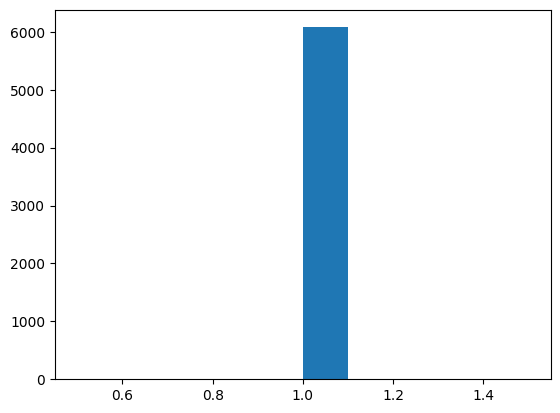

MAX: 1 
MEDIAN: 1
MEAN: 1
These are the results before any data-preprocessing on the category


In [ ]:
#We are trying to determine what should be the allowed maximum length of category

#Create a empty list
length_category = []

#Iterate the reviewText and make a list of sentences
for sen in df_train["category"]:
  length = len(sen.split())
  length_category.append(length)

#Plot a histogram to show the length of each sentence
plt.hist(length_category)
plt.show()

#Print the descriptive statistics
print("MAX: {} ".format(max(length_category)))
print("MEDIAN: {}".format(statistics.median(length_category)))
print("MEAN: {}".format(statistics.mean(length_category)))
print("These are the results before any data-preprocessing on the category")

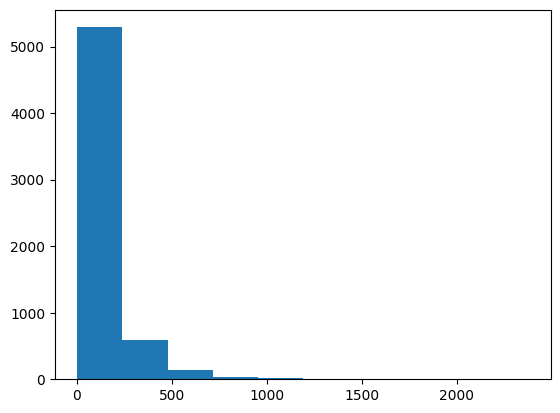

MAX: 2376 
MEDIAN: 88
MEAN: 133.0222075999342
These are the results before any data-preprocessing on the answer


In [ ]:
#We are trying to determine what should be the allowed maximum length of category

#Create a empty list
length_answer = []

#Iterate the reviewText and make a list of sentences
for sen in df_train["answer"]:
  length = len(sen.split())
  length_answer.append(length)

#Plot a histogram to show the length of each sentence
plt.hist(length_answer)
plt.show()

#Print the descriptive statistics
print("MAX: {} ".format(max(length_answer)))
print("MEDIAN: {}".format(statistics.median(length_answer)))
print("MEAN: {}".format(statistics.mean(length_answer)))
print("These are the results before any data-preprocessing on the answer")

**Based on the histogram and descriptive statistics of category, question_title and question_body, we determine that the maximum allowed length (max_length) for the 3 attributes are as follows:(Taking 1.5x as factor on 75th Percentile)<br>
category: 1 (Based on the Histogram)<br>
question_title: 1.5x 11 = 16.5<br>
question_body: 1.5x 154 = 231<br>
answer: 1.5x 133 = 200<br>**


### MODEL BUILDING

In [ ]:
#Makeing a list of all the label columns
cols = ['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']

In [ ]:
#Checking the length to make sure it is 30
len(cols)

30

**There are 2 types of prediction model that we will build; one is with just questions & the other is question-answer pair.<br>  
question_title, question_body, category > question_ labels [for Questions Only Model]<br>
question_title, question_body, answer, category > answer_ labels [for Question-Ansewer Pair Model]**

In [ ]:
#Based on the analysis of max length above defining the max length values
#Here qt: question_title, qb: question_body and a: answer
MODEL_MAX_LENGTH_qt = 16 
MODEL_MAX_LENGTH_qb = 232
MODEL_MAX_LENGTH_a = 200

#Initilize the bert tokenizers for training the bert model
bert_tokenizer_category = AutoTokenizer.from_pretrained('bert-base-uncased',
                                          model_max_length = 5,
                                          padding_side = "right",
                                          truncation_side = "right")

bert_tokenizer_qt = AutoTokenizer.from_pretrained('bert-base-uncased',
                                          model_max_length = MODEL_MAX_LENGTH_qt,
                                          padding_side = "right",
                                          truncation_side = "right")
bert_tokenizer_qb = AutoTokenizer.from_pretrained('bert-base-uncased',
                                          model_max_length = MODEL_MAX_LENGTH_qb,
                                          padding_side = "right",
                                          truncation_side = "right")
bert_tokenizer_a = AutoTokenizer.from_pretrained('bert-base-uncased',
                                          model_max_length = MODEL_MAX_LENGTH_a,
                                          padding_side = "right",
                                          truncation_side = "right")

#Initilize the bert model
bert_model = AutoModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Check if we have GPU available
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
#Send the bert_model to the GPU
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
# Checking to see what should be the right max length for category
# bert_model.eval()
# with torch.no_grad():
#   x = bert_model(**bert_tokenizer_category('INSECT', padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True))['pooler_output'].numpy()
# x

### DATASET AND DATALOADER DEFINITION

In [ ]:
#We are defining a custom collate function
def custom_collate(data):
    #Get the tockenizers from the collate_fn argument of the Dataloader 
    bert_tokenizer_qt = data[0][4]
    bert_tokenizer_qb = data[0][5]
    bert_tokenizer_a = data[0][6]
    bert_tokenizer_category = data[0][7]
    #Get the training data from the collate_fn argument of the Dataloader
    X_qt = [i[0] for i in data]
    X_qb = [i[1] for i in data]
    X_a = [i[2] for i in data]
    X_c = [i[3] for i in data]
    #The try-except block returns batches of tokenized data
    try:
        Y = [i[8] for i in data]
        return bert_tokenizer_qt(X_qt, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True), bert_tokenizer_qb(X_qb, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True),  bert_tokenizer_a(X_a, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True),  bert_tokenizer_category(X_c, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True), Y
    except:
        return bert_tokenizer_qt(X_qt, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True), bert_tokenizer_qb(X_qb, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True),  bert_tokenizer_a(X_a, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True),  bert_tokenizer_category(X_c, padding='max_length', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True)

In [ ]:
#Define a class for the dataloader to handel the tokenization
class QA_B_dataset(Dataset):
  #initilize the tokenizers, dataframe training attributes and a boolean to check
  #if the dataset input is for testing or training purpose
  def __init__(self, df, cols, bert_tokenizer_qt, bert_tokenizer_qb, bert_tokenizer_a, bert_tokenizer_category, is_test=False, **kwargs):
    super().__init__()
    self.bert_tokenizer_qt = bert_tokenizer_qt
    self.bert_tokenizer_qb = bert_tokenizer_qb
    self.bert_tokenizer_a = bert_tokenizer_a
    self.bert_tokenizer_category = bert_tokenizer_category
    self.X_qt = df['question_title']
    self.X_qb = df['question_body']
    self.X_a = df['answer']
    self.X_c = df['category']
    self.is_test=is_test
    if not self.is_test:
        self.Y = df[cols]
  
  #Gives the shape of the   
  def __len__(self):
    return self.X_qt.shape[0]

  #Based on if the dataset is training or testing we tokenize using the bert_tokenizer
  #from out custom_collate function
  def __getitem__(self, idx):
    # x_encoded = self.tokenizer(self.X[idx], padding='longest', truncation='longest_first', return_tensors='pt', return_attention_mask=True, return_token_type_ids=True)
    if not self.is_test:
        return self.X_qt.iloc[idx], self.X_qb.iloc[idx], self.X_a.iloc[idx], self.X_c.iloc[idx], bert_tokenizer_qt, bert_tokenizer_qb, bert_tokenizer_a, bert_tokenizer_category, self.Y.iloc[idx].values
    else:
        return self.X_qt.iloc[idx], self.X_qb.iloc[idx], self.X_a.iloc[idx], self.X_c.iloc[idx], bert_tokenizer_qt, bert_tokenizer_qb, bert_tokenizer_a, bert_tokenizer_category

In [ ]:
#Defining the batch size
BATCH_SIZE = 64

In [ ]:
#Initilize the dataloader class with all the required arguments
dataloader_train = DataLoader(QA_B_dataset(df_train, cols, bert_tokenizer_qt, bert_tokenizer_qb, bert_tokenizer_a, bert_tokenizer_category), batch_size=BATCH_SIZE, collate_fn=custom_collate)

In [ ]:
# Batch index - the variable
# 0 - qt
# 1 - qb
# 2 - a
# 3 - c
bert_model.eval()

#Create empty lists to store the batches
X_qt = []
X_qb = []
X_a = []
X_c = []
Y = []

#Iterate through the dataloader
for batch in tqdm(dataloader_train):
    with torch.no_grad():
      output_type = 'pooler_output' # last_hidden_state or pooler_output
      #training the batched data using bert_model
      out_qt = bert_model(**batch[0].to(device))[output_type].cpu().numpy()
      out_qb = bert_model(**batch[1].to(device))[output_type].cpu().numpy()
      out_a = bert_model(**batch[2].to(device))[output_type].cpu().numpy()
      out_c = bert_model(**batch[3].to(device))[output_type].cpu().numpy()
    #Stacking the batched labels 
    out_y = np.stack(batch[4])
    #Appending the trained model to the lists that we created
    X_qt.append(out_qt)
    X_qb.append(out_qb)
    X_a.append(out_a)
    X_c.append(out_c)
    Y.append(out_y)

  0%|          | 0/95 [00:00<?, ?it/s]

In [ ]:
#Concatenate the processed data and reshape such that we define the dimentions(768)
#and sentence(1), th-1 is for model to figureout
X_qt = np.concatenate(X_qt).reshape(-1,1,768)
X_qb = np.concatenate(X_qb).reshape(-1,1,768)
X_a = np.concatenate(X_a).reshape(-1,1,768)
X_c = np.concatenate(X_c).reshape(-1,1,768)
Y = np.concatenate(Y)

In [ ]:
# for questions only
X_questions = np.concatenate([X_c, X_qt, X_qb], axis = 1)

# for question answer pair
X_answers = np.concatenate([X_c, X_qt, X_qb, X_a], axis = 1)

### ONE COLUMN POC MODEL

**Generating a model on just one column to test if everything is running properly<br>
question_asker_intent_understanding**  

In [ ]:
#Define Column to be trained
column_for_model = "question_asker_intent_understanding"

In [ ]:
#Define total number of rows
total_rows = X_questions.shape[0]

In [ ]:
#Load the model according to the condition if it is a question label or answer label
X_model = X_questions if column_for_model.startswith("question_") else X_answers
#Define the max length based on if it is question only model or question-answer piar model
MODEL_MAX_LENGTH = 3 if column_for_model.startswith("question_") else 4
#Check if the data is balanced amd according implement oversampling method
if df_train[column_for_model].value_counts(normalize = True).iloc[0] > 0.85:
    X_resampled, y_resampled = array_oversampler(X_model.reshape(total_rows, -1), Y[:,cols.index(column_for_model)])
else:
    X_resampled, y_resampled = X_model, Y[:,cols.index(column_for_model)]

In [ ]:
#Reshape the data to required shape and attributes for both training data and labels
X_resampled = X_resampled.reshape(-1, MODEL_MAX_LENGTH, 768)
y_resampled = pd.get_dummies(y_resampled).values

In [ ]:
#Generate Train-Test Sets
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled,y_resampled, test_size = 0.25, random_state = 42)

In [ ]:
lstm_out = 64 
# embid_dim = embedding_width # This needs to match the width of our gloVe vectors

#Initilize the model
model = keras.Sequential()

# The big difference here is that the embedding values are set to not trainable
# model.add(Embedding(vocab_size, embid_dim, input_length =X.shape[1], weights = [embedding_matrix] , trainable = False))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2), input_shape=(MODEL_MAX_LENGTH,768)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'sigmoid'))
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_31 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_93 (Dense)            (None, 128)               16512     
                                                                 
 dropout_62 (Dropout)        (None, 128)               0         
                                                                 
 dense_94 (Dense)            (None, 64)                8256      
                                                                 
 dropout_63 (Dropout)        (None, 64)                0         
                                                                 
 dense_95 (Dense)            (None, 2)                 130       
                                                     

In [ ]:
#assign the model batch size
batch_size = 64
#Compile the model with appropriate arguments
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
##Fit the model to get training and validation accuracy
history = model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size, verbose = 1, validation_data =(X_test, Y_test))

Epoch 1/5


### FUNCTION FOR MODEL FOR COLUMN

In [ ]:
#Defining a function to perform all the tasks above so that we can just pass the
#column name(label) and get the trained model for each label
def model_builder(column_for_model):
    #Declare a global variable
    global dict_accuracies
    #print the name of column being trained
    print(f"running for {column_for_model}")
    #Define the model name
    MODEL_NAME = f"bert_lstm_-_{column_for_model}"

    #Load the model according to the condition if it is a question label or answer label
    X_model = X_questions if column_for_model.startswith("question_") else X_answers

    #Define the max length based on if it is question only model or question-answer piar model
    MODEL_MAX_LENGTH = 3 if column_for_model.startswith("question_") else 4

    #Check if the data is balanced amd according implement oversampling method
    if df_train[column_for_model].value_counts(normalize = True).iloc[0] > 0.85:
        X_resampled, y_resampled = array_oversampler(X_model.reshape(total_rows, -1), Y[:,cols.index(column_for_model)])
    else:
        X_resampled, y_resampled = X_model, Y[:,cols.index(column_for_model)]
    
    #Reshape the data to required shape and attributes for both training data and labels
    X_resampled = X_resampled.reshape(-1, MODEL_MAX_LENGTH, 768)
    y_resampled = pd.get_dummies(y_resampled).values

    #Generate Train-Test Sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_resampled,y_resampled, test_size = 0.25, random_state = 42)

    #Define the max length based on if it is question only model or question-answer piar model
    MODEL_MAX_LENGTH = 3 if column_for_model.startswith("question_") else 4
    lstm_out = 64 
    # embid_dim = embedding_width # This needs to match the width of our gloVe vectors

    #Initilize the model
    model = keras.Sequential()

    # The big difference here is that the embedding values are set to not trainable
    # model.add(Embedding(vocab_size, embid_dim, input_length =X.shape[1], weights = [embedding_matrix] , trainable = False))
    model.add(Bidirectional(LSTM(lstm_out, dropout=0.2), input_shape=(MODEL_MAX_LENGTH,768)))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation = 'sigmoid'))
    model.summary()

    #assign the model batch size
    batch_size = 64
    #Compile the model with appropriate arguments
    model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
    ##Fit the model to get training and validation accuracy
    history = model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 1, validation_data =(X_test, Y_test))
    #print the necessary details
    print()
    print(column_for_model, end="\n\n")
    print(f"Last Layer Training Accuracy : {history.history['accuracy'][-1]:.2%}")
    print(f"Last Layer Validation Accuracy : {history.history['val_accuracy'][-1]:.2%}")
    #append the results of the model to dictonary
    dict_accuracies[column_for_model]['training_accuracy'] = history.history['accuracy'][-1]
    dict_accuracies[column_for_model]['validation_accuracy'] = history.history['val_accuracy'][-1]
    print("\n\n\n")
    #Save the model to be reused
    model.save(f"/content/drive/MyDrive/NLP_Project/Trained_Models/{MODEL_NAME}")


### MODEL TRAINING LOOP

In [ ]:
#Create a dictonary
dict_accuracies = defaultdict(dict)
#Iterate over the columns and build models
for col in tqdm(cols[:]):
    model_builder(col)

  0%|          | 0/30 [00:00<?, ?it/s]

running for question_asker_intent_understanding
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_32 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_96 (Dense)            (None, 128)               16512     
                                                                 
 dropout_64 (Dropout)        (None, 128)               0         
                                                                 
 dense_97 (Dense)            (None, 64)                8256      
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                                                                 
 dense_98 (Dense)            (None, 2)                 130       
     

running for question_body_critical
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_33 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_99 (Dense)            (None, 128)               16512     
                                                                 
 dropout_66 (Dropout)        (None, 128)               0         
                                                                 
 dense_100 (Dense)           (None, 64)                8256      
                                                                 
 dropout_67 (Dropout)        (None, 64)                0         
                                                                 
 dense_101 (Dense)           (None, 2)                 130       
                  

running for question_conversational
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_34 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_102 (Dense)           (None, 128)               16512     
                                                                 
 dropout_68 (Dropout)        (None, 128)               0         
                                                                 
 dense_103 (Dense)           (None, 64)                8256      
                                                                 
 dropout_69 (Dropout)        (None, 64)                0         
                                                                 
 dense_104 (Dense)           (None, 2)                 130       
                 

running for question_expect_short_answer
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_35 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_105 (Dense)           (None, 128)               16512     
                                                                 
 dropout_70 (Dropout)        (None, 128)               0         
                                                                 
 dense_106 (Dense)           (None, 64)                8256      
                                                                 
 dropout_71 (Dropout)        (None, 64)                0         
                                                                 
 dense_107 (Dense)           (None, 2)                 130       
            

running for question_fact_seeking
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_36 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_108 (Dense)           (None, 128)               16512     
                                                                 
 dropout_72 (Dropout)        (None, 128)               0         
                                                                 
 dense_109 (Dense)           (None, 64)                8256      
                                                                 
 dropout_73 (Dropout)        (None, 64)                0         
                                                                 
 dense_110 (Dense)           (None, 2)                 130       
                   

running for question_has_commonly_accepted_answer
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_37 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_111 (Dense)           (None, 128)               16512     
                                                                 
 dropout_74 (Dropout)        (None, 128)               0         
                                                                 
 dense_112 (Dense)           (None, 64)                8256      
                                                                 
 dropout_75 (Dropout)        (None, 64)                0         
                                                                 
 dense_113 (Dense)           (None, 2)                 130       
   

running for question_interestingness_others
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_38 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_114 (Dense)           (None, 128)               16512     
                                                                 
 dropout_76 (Dropout)        (None, 128)               0         
                                                                 
 dense_115 (Dense)           (None, 64)                8256      
                                                                 
 dropout_77 (Dropout)        (None, 64)                0         
                                                                 
 dense_116 (Dense)           (None, 2)                 130       
         

running for question_interestingness_self
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_39 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_117 (Dense)           (None, 128)               16512     
                                                                 
 dropout_78 (Dropout)        (None, 128)               0         
                                                                 
 dense_118 (Dense)           (None, 64)                8256      
                                                                 
 dropout_79 (Dropout)        (None, 64)                0         
                                                                 
 dense_119 (Dense)           (None, 2)                 130       
           

running for question_multi_intent
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_40 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_120 (Dense)           (None, 128)               16512     
                                                                 
 dropout_80 (Dropout)        (None, 128)               0         
                                                                 
 dense_121 (Dense)           (None, 64)                8256      
                                                                 
 dropout_81 (Dropout)        (None, 64)                0         
                                                                 
 dense_122 (Dense)           (None, 2)                 130       
                   

running for question_not_really_a_question
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_41 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_123 (Dense)           (None, 128)               16512     
                                                                 
 dropout_82 (Dropout)        (None, 128)               0         
                                                                 
 dense_124 (Dense)           (None, 64)                8256      
                                                                 
 dropout_83 (Dropout)        (None, 64)                0         
                                                                 
 dense_125 (Dense)           (None, 2)                 130       
          

running for question_opinion_seeking
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_42 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_126 (Dense)           (None, 128)               16512     
                                                                 
 dropout_84 (Dropout)        (None, 128)               0         
                                                                 
 dense_127 (Dense)           (None, 64)                8256      
                                                                 
 dropout_85 (Dropout)        (None, 64)                0         
                                                                 
 dense_128 (Dense)           (None, 2)                 130       
                

running for question_type_choice
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_43 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_129 (Dense)           (None, 128)               16512     
                                                                 
 dropout_86 (Dropout)        (None, 128)               0         
                                                                 
 dense_130 (Dense)           (None, 64)                8256      
                                                                 
 dropout_87 (Dropout)        (None, 64)                0         
                                                                 
 dense_131 (Dense)           (None, 2)                 130       
                    

running for question_type_compare
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_44 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_132 (Dense)           (None, 128)               16512     
                                                                 
 dropout_88 (Dropout)        (None, 128)               0         
                                                                 
 dense_133 (Dense)           (None, 64)                8256      
                                                                 
 dropout_89 (Dropout)        (None, 64)                0         
                                                                 
 dense_134 (Dense)           (None, 2)                 130       
                   

running for question_type_consequence
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_45 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_135 (Dense)           (None, 128)               16512     
                                                                 
 dropout_90 (Dropout)        (None, 128)               0         
                                                                 
 dense_136 (Dense)           (None, 64)                8256      
                                                                 
 dropout_91 (Dropout)        (None, 64)                0         
                                                                 
 dense_137 (Dense)           (None, 2)                 130       
               

running for question_type_definition
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_46 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_138 (Dense)           (None, 128)               16512     
                                                                 
 dropout_92 (Dropout)        (None, 128)               0         
                                                                 
 dense_139 (Dense)           (None, 64)                8256      
                                                                 
 dropout_93 (Dropout)        (None, 64)                0         
                                                                 
 dense_140 (Dense)           (None, 2)                 130       
                

running for question_type_entity
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_47 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_141 (Dense)           (None, 128)               16512     
                                                                 
 dropout_94 (Dropout)        (None, 128)               0         
                                                                 
 dense_142 (Dense)           (None, 64)                8256      
                                                                 
 dropout_95 (Dropout)        (None, 64)                0         
                                                                 
 dense_143 (Dense)           (None, 2)                 130       
                    

running for question_type_instructions
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_48 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_144 (Dense)           (None, 128)               16512     
                                                                 
 dropout_96 (Dropout)        (None, 128)               0         
                                                                 
 dense_145 (Dense)           (None, 64)                8256      
                                                                 
 dropout_97 (Dropout)        (None, 64)                0         
                                                                 
 dense_146 (Dense)           (None, 2)                 130       
              

running for question_type_procedure
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_49 (Bidirecti  (None, 128)              426496    
 onal)                                                           
                                                                 
 dense_147 (Dense)           (None, 128)               16512     
                                                                 
 dropout_98 (Dropout)        (None, 128)               0         
                                                                 
 dense_148 (Dense)           (None, 64)                8256      
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_149 (Dense)           (None, 2)                 130       
                 

In [ ]:
# batch[0]['input_ids']
# batch[0]['token_type_ids']
# batch[0]['attention_mask'].size(),batch[1]['attention_mask'].size(), torch.concat((batch[0]['attention_mask'],batch[1]['attention_mask']), dim=1).size()

In [ ]:
# for qa, qb, a, cat
#     dataloader : embeddings --> y (any of the 30)
# for labels:
#     oversample 
#     model.compile
#     model.save(label)


### PREDICTION

In [ ]:
#Import the test dataset
df_test = pd.read_csv("/content/drive/MyDrive/NLP_Project/test.csv")

In [ ]:
#View first 6 records
df_test.head()

In [ ]:
#Initilize a dataloader for test dataset
dataloader_test = DataLoader(QA_B_dataset(df_test, cols, bert_tokenizer_qt, bert_tokenizer_qb, bert_tokenizer_a, bert_tokenizer_category, is_test=True), batch_size=BATCH_SIZE, collate_fn=custom_collate)

In [ ]:
bert_model.eval()

#Create empty lists
X_qt = []
X_qb = []
X_a = []
X_c = []

#Iterate through the test dataloader
for batch in tqdm(dataloader_test):
    with torch.no_grad():
      output_type = 'pooler_output' # last_hidden_state or pooler_output
      #Train the data using bert model (for embed)
      out_qt = bert_model(**batch[0].to(device))[output_type].cpu().numpy()
      out_qb = bert_model(**batch[1].to(device))[output_type].cpu().numpy()
      out_a = bert_model(**batch[2].to(device))[output_type].cpu().numpy()
      out_c = bert_model(**batch[3].to(device))[output_type].cpu().numpy()
    #Append the data
    X_qt.append(out_qt)
    X_qb.append(out_qb)
    X_a.append(out_a)
    X_c.append(out_c)

In [ ]:
#concatenate the results and reshape them required input shape
X_qt = np.concatenate(X_qt).reshape(-1,1,768)
X_qb = np.concatenate(X_qb).reshape(-1,1,768)
X_a = np.concatenate(X_a).reshape(-1,1,768)
X_c = np.concatenate(X_c).reshape(-1,1,768)

In [ ]:
# for questions only
X_questions_test = np.concatenate([X_c, X_qt, X_qb], axis = 1)

# for question answer pair
X_answers_test = np.concatenate([X_c, X_qt, X_qb, X_a], axis = 1)

In [ ]:
#Define a model prediction function which uploads the trained model based on the 
#label and makes prediction on the test data
def model_predict(column_for_model):
    #Define a global variable
    global result_dict
    #Print the column that is being predicted
    print(f"running predictions for {column_for_model}")
    #Import the traind model for the label to be predicted
    MODEL_NAME = f"/content/drive/MyDrive/NLP_Project/Trained_Models/bert_lstm_-_{column_for_model}"

    #Load the model according to the condition if it is a question label or answer label
    X_model = X_questions_test if column_for_model.startswith("question_") else X_answers_test

    #Define the max length based on if it is question only model or question-answer piar model
    MODEL_MAX_LENGTH = 3 if column_for_model.startswith("question_") else 4

    #Since we don't have any labels for the data
    X_resampled = X_model
    
    #Reshape to the required input shape
    X_resampled = X_resampled.reshape(-1, MODEL_MAX_LENGTH, 768)

    #Define the max length based on if it is question only model or question-answer piar model
    MODEL_MAX_LENGTH = 3 if column_for_model.startswith("question_") else 4
    lstm_out = 64 

    #Load the model
    model = keras.models.load_model(MODEL_NAME)

    #Define the model batch size
    batch_size = 64

    #Make the prediction using the trained model
    Y_pred = model.predict(X_resampled, batch_size=BATCH_SIZE)
    
    #Taking the label with max probability
    Y_pred = Y_pred.argmax(axis = 1)

    #Return the predicted results
    return Y_pred

In [ ]:
#Generate an empty dictionary
result_dict = {}

#Iterate through the columns and store the predictions in the dictionary
for col in tqdm(cols): 
    result_dict[col] = model_predict(col)

In [ ]:
#Create a dataframe of the dictionary
df_pred = pd.DataFrame(result_dict)

In [ ]:
#Display the predicted value counts for each label
for col in cols:
    display(df_pred[col].value_counts())

### RESULT ANALYSIS

In [ ]:
#Create adataframe of all the training and validation accuracies
res_df = pd.DataFrame(dict_accuracies).T

In [ ]:
#Create a round function to convert the accuracies to percentages and the round
#them to 2 decimal places
round_fn = lambda x: round(x*100, 2)
#Apply the dunction to the dataframe accuracy columns
res_df["training_accuracy"] = res_df["training_accuracy"].apply(round_fn)
res_df["validation_accuracy"] = res_df["validation_accuracy"].apply(round_fn)

In [ ]:
#View the dataset
res_df

,training_accuracy,validation_accuracy
question_asker_intent_understanding,86.75,88.61
question_body_critical,71.22,72.63
question_conversational,86.36,85.97
question_expect_short_answer,78.28,77.76
question_fact_seeking,79.97,81.64
question_has_commonly_accepted_answer,83.75,84.21
question_interestingness_others,73.72,74.74
question_interestingness_self,72.38,72.24
question_multi_intent,77.74,76.78
question_not_really_a_question,99.21,99.72
